In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

 

 
device = torch.device('cuda' if torch.cuda.is_available() 
                      else 'mps' if torch.backends.mps.is_available() 
                      else 'cpu')
print("Using device :", device)

 
transform_8x8 = transforms.Compose([
    transforms.Resize((8,8)),   
    transforms.ToTensor()
])

batch_size = 128

train_dataset = datasets.MNIST(
    root='mnist_data', train=True, download=True, transform=transform_8x8
)
test_dataset = datasets.MNIST(
    root='mnist_data', train=False, download=True, transform=transform_8x8
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2)

# MNIST is grayscale, so each image is now (1, 8, 8). We'll flatten to 64.
input_dim = 8 * 8  # =64

 

Using device : mps


In [6]:

# Base Distribution: Standard Normal
 
class StandardNormal:
    """Simple standard Normal as a base distribution."""
    def __init__(self, shape):
        self.shape = shape

    def log_prob(self, z):
        # log p(z) = -1/2 (z^2 + log(2π)) summed over dims
        return -0.5 * (z**2 + torch.log(torch.tensor(2.0*np.pi))).sum(dim=1)

    def sample(self, batch_size):
        return torch.randn(batch_size, *self.shape).to(device)

 
#  Coupling Flow (RealNVP-like)
 
class CouplingLayer(nn.Module):
    """
    One coupling layer in RealNVP style. 
    We split the input: x = [x1, x2].
    Transform x2 with an affine function of x1.
    """
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.D = input_dim // 2

        self.nn_scale = nn.Sequential(
            nn.Linear(self.D, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.D)
        )
        self.nn_trans = nn.Sequential(
            nn.Linear(self.D, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.D)
        )

    def forward(self, x, reverse=False):
        x1 = x[:, :self.D]
        x2 = x[:, self.D:]

        s = self.nn_scale(x1)
        t = self.nn_trans(x1)
        s = torch.tanh(s) * 1.5  # clamp scale for stability

        if not reverse:
            # Forward: x2 -> z2
            z2 = x2 * torch.exp(s) + t
            z = torch.cat([x1, z2], dim=1)
            log_det_jac = s.sum(dim=1)
        else:
            # Inverse: z2 -> x2
            z2 = (x2 - t) * torch.exp(-s)
            z = torch.cat([x1, z2], dim=1)
            log_det_jac = -s.sum(dim=1)

        return z, log_det_jac


class RealNVP(nn.Module):
    """Chain multiple RealNVP coupling layers."""
    def __init__(self, input_dim, hidden_dim=128, num_flows=4):
        super().__init__()
        self.layers = nn.ModuleList([
            CouplingLayer(input_dim, hidden_dim) for _ in range(num_flows)
        ])
        self.base_dist = StandardNormal((input_dim,))

    def forward(self, x):
        """x -> z, accumulate log|det|."""
        log_det = 0.0
        z = x
        for layer in self.layers:
            z, ld = layer(z, reverse=False)
            log_det += ld
        return z, log_det

    def inverse(self, z):
        """z -> x, accumulate log|det| of inverse."""
        log_det = 0.0
        x = z
        for layer in reversed(self.layers):
            x, ld = layer(x, reverse=True)
            log_det += ld
        return x, log_det

    def log_prob(self, x):
        """log p(x) = log p(z) + log|det(dz/dx)|."""
        z, log_det = self.forward(x)
        log_p_z = self.base_dist.log_prob(z)
        return log_p_z + log_det

    def sample(self, batch_size):
        """Sample by drawing z and inverting."""
        z = self.base_dist.sample(batch_size)
        x, _ = self.inverse(z)
        return x

 
# Autoregressive Flow (MAF-like)
 
class MaskedLinear(nn.Module):
    """A linear layer that applies a mask (for autoregressive connections)."""
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.register_buffer('mask', torch.ones(out_features, in_features))

    def set_mask(self, mask):
        self.mask = mask

    def forward(self, x):
        return F.linear(x, self.linear.weight * self.mask, self.linear.bias)


class AutoregressiveBlock(nn.Module):
    """
    One MAF block:
    z = x * exp(s) + t,
    where s,t are predicted by a masked network from x.
    """
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            MaskedLinear(input_dim, hidden_dim),
            nn.ReLU(),
            MaskedLinear(hidden_dim, hidden_dim),
            nn.ReLU(),
            MaskedLinear(hidden_dim, 2 * input_dim)
        )

    def forward(self, x, reverse=False):
        if not reverse:
            out = self.net(x)
            s, t = out.chunk(2, dim=1)
            s = torch.tanh(s) * 1.5
            z = x * torch.exp(s) + t
            log_det_jac = s.sum(dim=1)
            return z, log_det_jac
        else:
            # Inverse pass (z -> x) dimension by dimension
            x_inv = torch.zeros_like(x)
            log_det_jac = torch.zeros(x.size(0), device=device)
            for i in range(x.size(1)):
                out = self.net(x_inv)
                s, t = out.chunk(2, dim=1)
                si = s[:, i].unsqueeze(1)
                ti = t[:, i].unsqueeze(1)
                x_inv[:, i] = (x[:, i] - ti.squeeze(1)) * torch.exp(-si.squeeze(1))
                log_det_jac += -si.squeeze(1)
            return x_inv, log_det_jac


class MAF(nn.Module):
    """A Masked Autoregressive Flow using multiple autoregressive blocks."""
    def __init__(self, input_dim, hidden_dim=128, num_flows=4):
        super().__init__()
        self.blocks = nn.ModuleList([
            AutoregressiveBlock(input_dim, hidden_dim) for _ in range(num_flows)
        ])
        self.input_dim = input_dim
        self.base_dist = StandardNormal((input_dim,))

        # Build the masks to ensure autoregressive property
        for block in self.blocks:
            self._make_autoregressive_masks(block, input_dim, hidden_dim)

    def _make_autoregressive_masks(self, block, input_dim, hidden_dim):
        """
        Minimal example of creating a lower-triangular mask for each MaskedLinear
        to achieve the autoregressive property (MADE-like).
        """
        layers = [l for l in block.net if isinstance(l, MaskedLinear)]
        D = input_dim

        def create_mask(in_feats, out_feats, order_in, order_out):
            mask = torch.zeros(out_feats, in_feats)
            for j in range(out_feats):
                for i in range(in_feats):
                    if order_in[i] < order_out[j]:
                        mask[j, i] = 1
            return mask

        order_input = list(range(D))
        # first masked linear
        ml1 = layers[0]
        out_feats1 = ml1.linear.out_features
        order_h1 = np.random.randint(1, D, size=out_feats1)
        order_h1 = np.clip(order_h1, 1, D-1)
        order_h1 = sorted(order_h1)
        mask1 = create_mask(D, out_feats1, order_input, order_h1)
        ml1.set_mask(mask1)

        # second masked linear
        ml2 = layers[1]
        out_feats2 = ml2.linear.out_features
        order_h2 = np.random.randint(1, D, size=out_feats2)
        order_h2 = np.clip(order_h2, 1, D-1)
        order_h2 = sorted(order_h2)
        mask2 = create_mask(out_feats1, out_feats2, order_h1, order_h2)
        ml2.set_mask(mask2)

        # final masked linear
        ml3 = layers[2]
        out_feats3 = ml3.linear.out_features
        # e.g. 2*D => each dimension for s,t
        order_out = np.array([i % D for i in range(out_feats3)])
        mask3 = create_mask(out_feats2, out_feats3, order_h2, order_out)
        ml3.set_mask(mask3)

    def forward(self, x):
        log_det = 0.0
        z = x
        for block in self.blocks:
            z, ld = block(z, reverse=False)
            log_det += ld
        return z, log_det

    def inverse(self, z):
        log_det = 0.0
        x = z
        for block in reversed(self.blocks):
            x, ld = block(x, reverse=True)
            log_det += ld
        return x, log_det

    def log_prob(self, x):
        z, log_det = self.forward(x)
        log_p_z = self.base_dist.log_prob(z)
        return log_p_z + log_det

    def sample(self, batch_size):
        z = self.base_dist.sample(batch_size)
        x, _ = self.inverse(z)
        return x



In [7]:

 
def train_flow(model, train_loader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for (data, _) in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            # flatten each image to 64-dim
            data = data.view(data.size(0), -1).to(device)
            optimizer.zero_grad()
            log_p = model.log_prob(data)  # log-likelihood
            loss = -log_p.mean()         # want to *maximize* log-likelihood
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * data.size(0)

        avg_loss = running_loss / len(train_loader.dataset)
        print(f"[Epoch {epoch+1}] avg NLL = {avg_loss:.4f}")

def evaluate_flow(model, test_loader):
    model.eval()
    total_log_prob = 0.0
    with torch.no_grad():
        for (data, _) in test_loader:
            data = data.view(data.size(0), -1).to(device)
            log_prob = model.log_prob(data)
            total_log_prob += log_prob.sum().item()
    avg_log_prob = total_log_prob / len(test_loader.dataset)
    return avg_log_prob

def plot_samples(model, n=8, title="Samples"):
    model.eval()
    with torch.no_grad():
        samples = model.sample(n*n).cpu().numpy()
    # reshape to 8x8
    samples = samples.reshape(-1, 8, 8)
    
    fig, axes = plt.subplots(n, n, figsize=(8, 8))
    idx = 0
    for i in range(n):
        for j in range(n):
            axes[i, j].imshow(samples[idx], cmap='gray')
            axes[i, j].axis('off')
            idx += 1
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()



Training MAF flow...


Epoch 1/10: 100%|██████████| 469/469 [00:05<00:00, 81.09it/s] 


[Epoch 1] avg NLL = -94.5500


Epoch 2/10: 100%|██████████| 469/469 [00:05<00:00, 88.24it/s] 


[Epoch 2] avg NLL = -133.8975


Epoch 3/10: 100%|██████████| 469/469 [00:06<00:00, 67.79it/s]


[Epoch 3] avg NLL = -143.3660


Epoch 4/10: 100%|██████████| 469/469 [00:05<00:00, 86.90it/s] 


[Epoch 4] avg NLL = -148.2547


Epoch 5/10: 100%|██████████| 469/469 [00:05<00:00, 79.12it/s] 


[Epoch 5] avg NLL = -150.9139


Epoch 6/10: 100%|██████████| 469/469 [00:05<00:00, 84.10it/s] 


[Epoch 6] avg NLL = -153.0549


Epoch 7/10: 100%|██████████| 469/469 [00:05<00:00, 88.61it/s] 


[Epoch 7] avg NLL = -154.6844


Epoch 8/10: 100%|██████████| 469/469 [00:05<00:00, 88.54it/s] 


[Epoch 8] avg NLL = -156.0089


Epoch 9/10: 100%|██████████| 469/469 [00:05<00:00, 88.38it/s] 


[Epoch 9] avg NLL = -157.3386


Epoch 10/10: 100%|██████████| 469/469 [00:05<00:00, 88.98it/s] 

[Epoch 10] avg NLL = -158.4862


MAF: Test avg log-likelihood = 153.8315


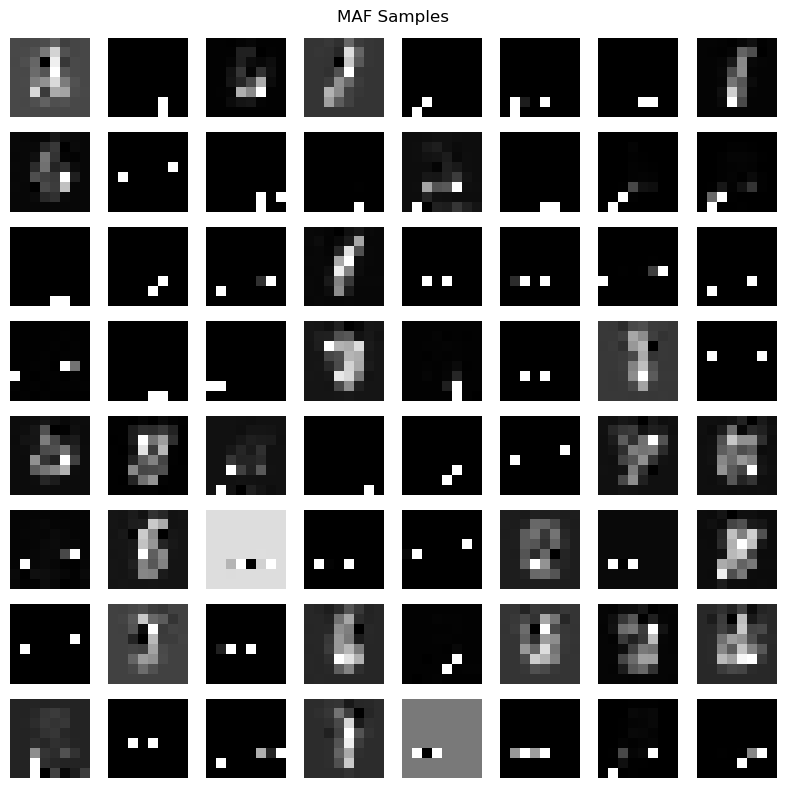

In [8]:


# realnvp_model = RealNVP(input_dim=input_dim, hidden_dim=256, num_flows=4).to(device)
# optimizer_rnvp = optim.Adam(realnvp_model.parameters(), lr=1e-3)
# print("\nTraining RealNVP flow...")
# train_flow(realnvp_model, train_loader, optimizer_rnvp, epochs=10)
# test_log_prob_rnvp = evaluate_flow(realnvp_model, test_loader)
# print(f"RealNVP: Test avg log-likelihood = {test_log_prob_rnvp:.4f}")
# plot_samples(realnvp_model, n=8, title="RealNVP Samples")

maf_model = MAF(input_dim=input_dim, hidden_dim=256, num_flows=4).to(device)
optimizer_maf = optim.Adam(maf_model.parameters(), lr=1e-3)
print("\nTraining MAF flow...")
train_flow(maf_model, train_loader, optimizer_maf, epochs=10)
test_log_prob_maf = evaluate_flow(maf_model, test_loader)
print(f"MAF: Test avg log-likelihood = {test_log_prob_maf:.4f}")
plot_samples(maf_model, n=8, title="MAF Samples")


Using device: mps

=== Training NICE flow (8×8 MNIST) ===


Epoch 1/10: 100%|██████████| 469/469 [00:13<00:00, 35.08it/s]


[Epoch 1] avg NLL= 44.1755


Epoch 2/10: 100%|██████████| 469/469 [00:13<00:00, 34.29it/s]


[Epoch 2] avg NLL= 14.1267


Epoch 3/10: 100%|██████████| 469/469 [00:14<00:00, 33.18it/s]


[Epoch 3] avg NLL= -15.3878


Epoch 4/10: 100%|██████████| 469/469 [00:13<00:00, 35.04it/s]


[Epoch 4] avg NLL= -44.1396


Epoch 5/10: 100%|██████████| 469/469 [00:13<00:00, 35.87it/s]


[Epoch 5] avg NLL= -71.2113


Epoch 6/10: 100%|██████████| 469/469 [00:13<00:00, 35.25it/s]


[Epoch 6] avg NLL= -95.2667


Epoch 7/10: 100%|██████████| 469/469 [00:12<00:00, 36.96it/s]


[Epoch 7] avg NLL= -114.5195


Epoch 8/10: 100%|██████████| 469/469 [00:12<00:00, 36.89it/s]


[Epoch 8] avg NLL= -128.3838


Epoch 9/10: 100%|██████████| 469/469 [00:12<00:00, 36.31it/s]


[Epoch 9] avg NLL= -137.9124


Epoch 10/10: 100%|██████████| 469/469 [00:15<00:00, 30.07it/s]

[Epoch 10] avg NLL= -143.9521


NICE: Test avg log-likelihood= 144.5794


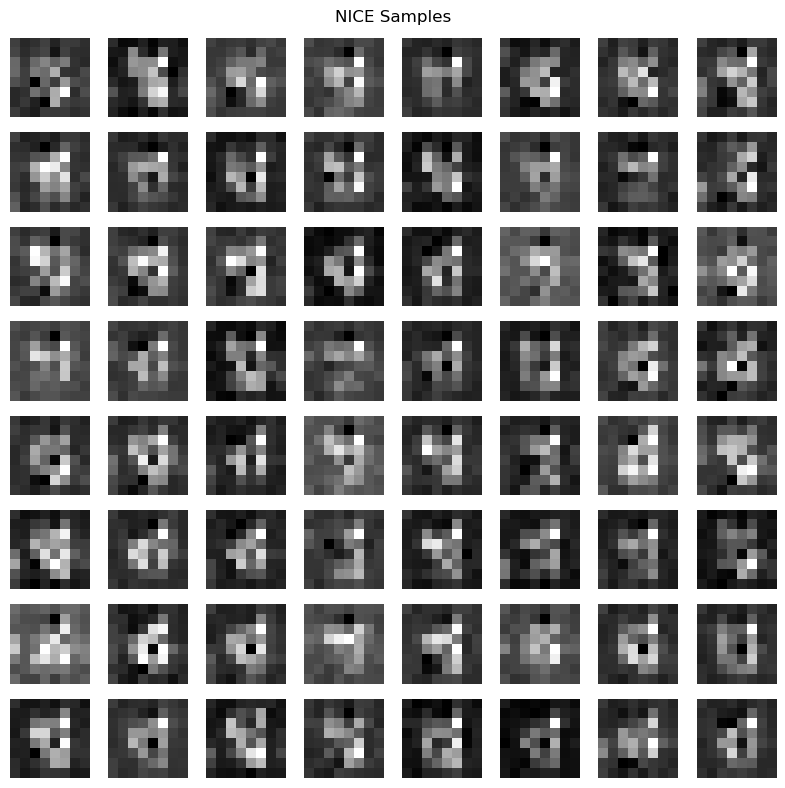


=== Training RealNVP flow (8×8 MNIST) ===


Epoch 1/10: 100%|██████████| 469/469 [00:07<00:00, 66.12it/s] 


[Epoch 1] avg NLL= -26.4848


Epoch 2/10: 100%|██████████| 469/469 [00:06<00:00, 71.95it/s]


[Epoch 2] avg NLL= -36.3798


Epoch 3/10: 100%|██████████| 469/469 [00:06<00:00, 70.47it/s] 


[Epoch 3] avg NLL= -38.7445


Epoch 4/10: 100%|██████████| 469/469 [00:06<00:00, 69.47it/s] 


[Epoch 4] avg NLL= -40.2187


Epoch 5/10: 100%|██████████| 469/469 [00:06<00:00, 73.52it/s] 


[Epoch 5] avg NLL= -41.2892


Epoch 6/10: 100%|██████████| 469/469 [00:06<00:00, 72.64it/s] 


[Epoch 6] avg NLL= -42.1019


Epoch 7/10: 100%|██████████| 469/469 [00:06<00:00, 67.28it/s]


[Epoch 7] avg NLL= -42.8223


Epoch 8/10: 100%|██████████| 469/469 [00:06<00:00, 67.86it/s]


[Epoch 8] avg NLL= -43.4384


Epoch 9/10: 100%|██████████| 469/469 [00:06<00:00, 68.82it/s]


[Epoch 9] avg NLL= -43.9732


Epoch 10/10: 100%|██████████| 469/469 [00:06<00:00, 77.93it/s] 

[Epoch 10] avg NLL= -44.3684


RealNVP: Test avg log-likelihood= 42.0158


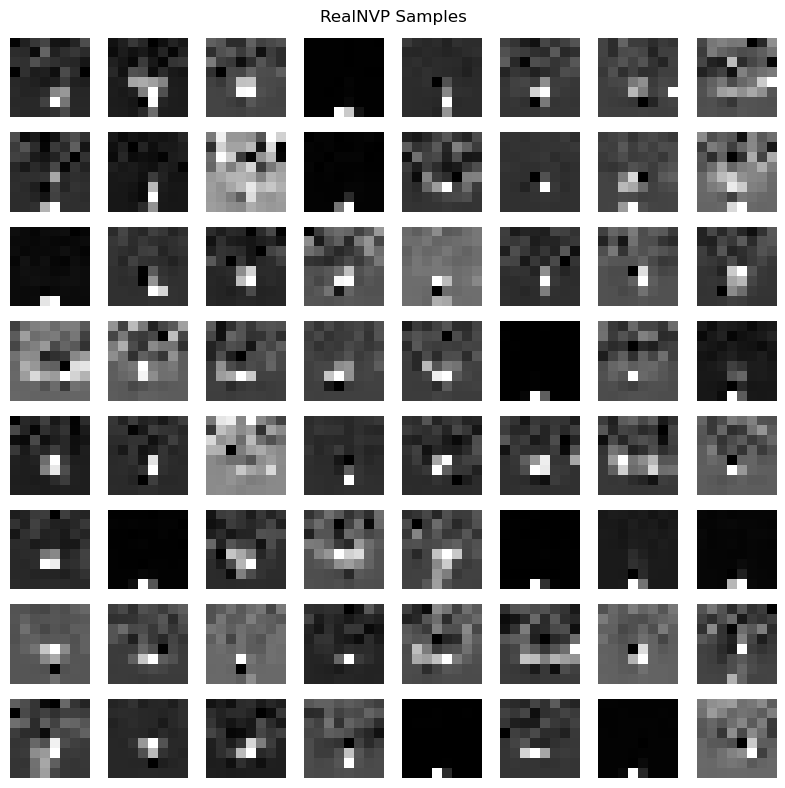


=== Training MAF flow (8×8 MNIST) ===


Epoch 1/10: 100%|██████████| 469/469 [00:05<00:00, 81.28it/s] 


[Epoch 1] avg NLL= -93.3482


Epoch 2/10: 100%|██████████| 469/469 [00:05<00:00, 80.30it/s] 


[Epoch 2] avg NLL= -134.9204


Epoch 3/10: 100%|██████████| 469/469 [00:05<00:00, 82.41it/s] 


[Epoch 3] avg NLL= -143.5839


Epoch 4/10: 100%|██████████| 469/469 [00:05<00:00, 87.63it/s] 


[Epoch 4] avg NLL= -148.2695


Epoch 5/10: 100%|██████████| 469/469 [00:05<00:00, 84.42it/s] 


[Epoch 5] avg NLL= -151.1551


Epoch 6/10: 100%|██████████| 469/469 [00:05<00:00, 84.34it/s] 


[Epoch 6] avg NLL= -153.3201


Epoch 7/10: 100%|██████████| 469/469 [00:05<00:00, 88.53it/s] 


[Epoch 7] avg NLL= -155.2826


Epoch 8/10: 100%|██████████| 469/469 [00:05<00:00, 83.08it/s] 


[Epoch 8] avg NLL= -156.6979


Epoch 9/10: 100%|██████████| 469/469 [00:05<00:00, 83.15it/s] 


[Epoch 9] avg NLL= -157.7840


Epoch 10/10: 100%|██████████| 469/469 [00:05<00:00, 84.01it/s] 

[Epoch 10] avg NLL= -158.7731


MAF: Test avg log-likelihood= 156.8160


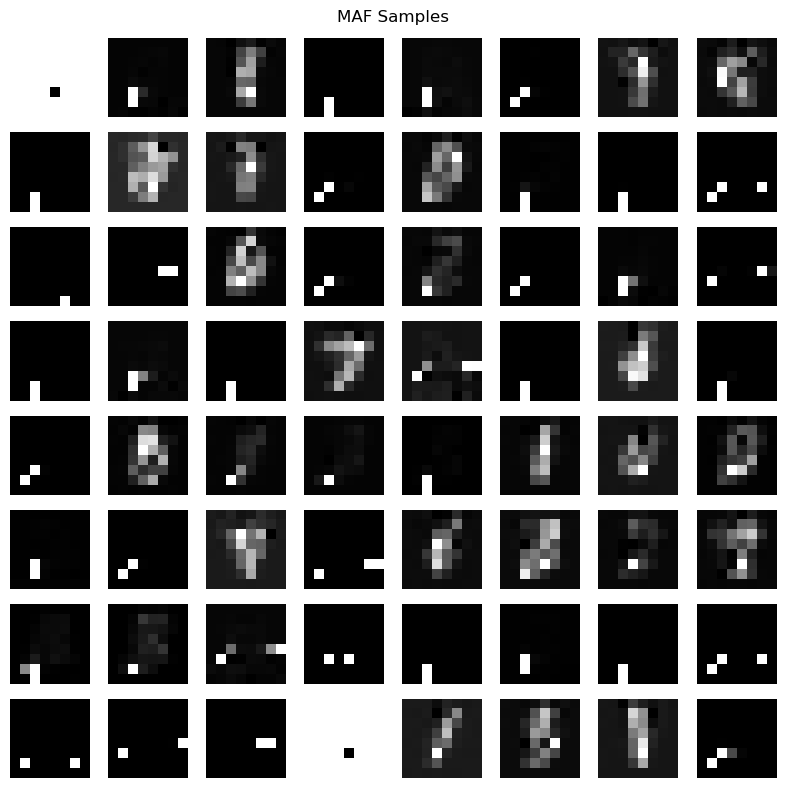

In [4]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

##################################################
# 1) Global Setup
##################################################
device = torch.device('cuda' if torch.cuda.is_available() 
                      else 'mps' if torch.backends.mps.is_available()
                      else 'cpu')
print("Using device:", device)

BATCH_SIZE = 128
EPOCHS     = 10
LR         = 1e-3

IMG_SIZE   = 8   # Downsample MNIST to 8×8 => dimension=64 (even)
INPUT_DIM  = IMG_SIZE * IMG_SIZE  # =64

##################################################
# 2) Data: MNIST to 8×8
##################################################
transform_8x8 = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
train_dataset = datasets.MNIST(root='mnist_data', train=True,  download=True, transform=transform_8x8)
test_dataset  = datasets.MNIST(root='mnist_data', train=False, download=True, transform=transform_8x8)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

##################################################
# 3) Base Distribution: Standard Normal
##################################################
class StandardNormal:
    """Simple standard Normal as a base distribution."""
    def __init__(self, shape):
        self.shape = shape
    def log_prob(self, z):
        # log p(z) = -1/2 (z^2 + log(2π)) summed over dims
        return -0.5 * (z**2 + torch.log(torch.tensor(2.0*np.pi))).sum(dim=1)
    def sample(self, batch_size):
        return torch.randn(batch_size, *self.shape, device=device)

##################################################
# 4) NICE Implementation (Additive Coupling + diag scale)
##################################################
def _get_even(x):
    return x[:, 0::2]
def _get_odd(x):
    return x[:, 1::2]

def _interleave(even_part, odd_part, which_partition):
    """Interleave columns from two partitions for an even input_dim=64."""
    cols = []
    # for 64 dims, even_part and odd_part each have 32 dims => no mismatch
    if which_partition=='even':
        for i in range(even_part.shape[1]):
            cols.append(even_part[:, i])
            cols.append(odd_part[:, i])
    else:
        for i in range(odd_part.shape[1]):
            cols.append(odd_part[:, i])
            cols.append(even_part[:, i])
    return torch.stack(cols, dim=1)

class NICECouplingLayer(nn.Module):
    """
    A single additive coupling layer from NICE:
      - 'even': x_even pass-thru, x_odd => x_odd + f(x_even)
      - 'odd':  x_odd pass-thru, x_even => x_even + f(x_odd)
    """
    def __init__(self, input_dim, partition, nn_module):
        super().__init__()
        assert (input_dim % 2==0), "NICE expects an even input dimension."
        self.input_dim = input_dim
        assert partition in ['even','odd']
        self.partition = partition
        self.nn_module= nn_module

    def forward(self, x):
        if self.partition=='even':
            x_even = _get_even(x)
            x_odd  = _get_odd(x)
            shift  = self.nn_module(x_even) # shape matches x_odd
            y_odd  = x_odd + shift
            y      = _interleave(x_even, y_odd, 'even')
        else:
            x_odd  = _get_odd(x)
            x_even = _get_even(x)
            shift  = self.nn_module(x_odd)
            y_even = x_even + shift
            y      = _interleave(y_even, x_odd, 'odd')
        return y

    def inverse(self, y):
        with torch.no_grad():
            if self.partition=='even':
                y_even = _get_even(y)
                y_odd  = _get_odd(y)
                shift  = self.nn_module(y_even)
                x_odd  = y_odd - shift
                x      = _interleave(y_even, x_odd, 'even')
            else:
                y_odd  = _get_odd(y)
                y_even = _get_even(y)
                shift  = self.nn_module(y_odd)
                x_even = y_even - shift
                x      = _interleave(x_even, y_odd, 'odd')
        return x

def _build_relu_network(latent_dim, hidden_dim, num_layers):
    """A feedforward net: (Linear->ReLU) repeated => out dimension=latent_dim."""
    modules = []
    modules.append(nn.Linear(latent_dim, hidden_dim))
    modules.append(nn.ReLU())
    for _ in range(num_layers-1):
        modules.append(nn.Linear(hidden_dim, hidden_dim))
        modules.append(nn.ReLU())
    modules.append(nn.Linear(hidden_dim, latent_dim))
    return nn.Sequential(*modules)

class NICEModel(nn.Module):
    """
    A NICE model with 4 additive coupling layers (alternating even/odd),
    plus a final diagonal log-scale param.
    For input_dim=64 => half=32 for each partition.
    """
    def __init__(self, input_dim, hidden_dim=256, num_layers=5):
        super().__init__()
        assert (input_dim % 2==0), "NICE requires an even input dimension."

        half_dim= input_dim//2
        # Build 4 couplings:
        net1= _build_relu_network(half_dim, hidden_dim, num_layers)
        net2= _build_relu_network(half_dim, hidden_dim, num_layers)
        net3= _build_relu_network(half_dim, hidden_dim, num_layers)
        net4= _build_relu_network(half_dim, hidden_dim, num_layers)

        self.layer1= NICECouplingLayer(input_dim, 'even', net1)
        self.layer2= NICECouplingLayer(input_dim, 'odd',  net2)
        self.layer3= NICECouplingLayer(input_dim, 'even', net3)
        self.layer4= NICECouplingLayer(input_dim, 'odd',  net4)

        self.scaling_diag= nn.Parameter(torch.zeros(input_dim))

    def forward(self, x):
        y= self.layer1(x)
        y= self.layer2(y)
        y= self.layer3(y)
        y= self.layer4(y)
        # final scale
        y= y* torch.exp(self.scaling_diag)
        return y

    def inverse(self, y):
        with torch.no_grad():
            scaled= y* torch.exp(-self.scaling_diag)
            x= self.layer4.inverse(scaled)
            x= self.layer3.inverse(x)
            x= self.layer2.inverse(x)
            x= self.layer1.inverse(x)
        return x

class NICEFlow(nn.Module):
    """
    Wrap NICEModel with log_prob, sample, etc.
    """
    def __init__(self, input_dim, hidden_dim=256, num_layers=5):
        super().__init__()
        self.model    = NICEModel(input_dim, hidden_dim, num_layers)
        self.base_dist= StandardNormal((input_dim,))

    def forward(self, x):
        y= self.model(x)
        # couplings => det=1, final diag => sum(scaling_diag)
        log_det_val= torch.sum(self.model.scaling_diag)
        batch_size= x.size(0)
        log_det_jac= log_det_val* torch.ones(batch_size, device=x.device)
        return y, log_det_jac

    def log_prob(self, x):
        y, log_det_jac= self.forward(x)
        log_p_y= self.base_dist.log_prob(y)
        return log_p_y+ log_det_jac

    def sample(self, batch_size):
        z= self.base_dist.sample(batch_size)
        x= self.model.inverse(z)
        return x


##################################################
# 5) RealNVP Implementation (Your Code)
##################################################
class CouplingLayer(nn.Module):
    """
    One coupling layer in RealNVP style. We split x=[x1,x2],
    transform x2 with affine function of x1.
    """
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.D = input_dim//2
        self.nn_scale = nn.Sequential(
            nn.Linear(self.D, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.D)
        )
        self.nn_trans = nn.Sequential(
            nn.Linear(self.D, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.D)
        )

    def forward(self, x, reverse=False):
        x1= x[:, :self.D]
        x2= x[:, self.D:]
        s= self.nn_scale(x1)
        t= self.nn_trans(x1)
        s= torch.tanh(s)*1.5
        if not reverse:
            z2= x2* torch.exp(s)+ t
            z = torch.cat([x1,z2], dim=1)
            log_det_jac= s.sum(dim=1)
        else:
            z2= (x2- t)* torch.exp(-s)
            z = torch.cat([x1,z2], dim=1)
            log_det_jac= -s.sum(dim=1)
        return z, log_det_jac

class RealNVPFlow(nn.Module):
    """
    RealNVP with multiple coupling layers.
    """
    def __init__(self, input_dim, hidden_dim=128, num_flows=4):
        super().__init__()
        self.layers= nn.ModuleList([
            CouplingLayer(input_dim, hidden_dim) for _ in range(num_flows)
        ])
        self.base_dist= StandardNormal((input_dim,))

    def forward(self, x):
        log_det=0.
        z= x
        for layer in self.layers:
            z, ld= layer(z, reverse=False)
            log_det+= ld
        return z, log_det

    def inverse(self, z):
        log_det=0.
        x= z
        for layer in reversed(self.layers):
            x, ld= layer(x, reverse=True)
            log_det+= ld
        return x, log_det

    def log_prob(self, x):
        z, log_det= self.forward(x)
        log_p_z= self.base_dist.log_prob(z)
        return log_p_z+ log_det

    def sample(self, batch_size):
        z= self.base_dist.sample(batch_size)
        x,_= self.inverse(z)
        return x

##################################################
# 6) MAF Implementation (Your Code)
##################################################
class MaskedLinear(nn.Module):
    """A linear layer that applies a mask (for autoregressive connections)."""
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear= nn.Linear(in_features, out_features)
        self.register_buffer('mask', torch.ones(out_features, in_features))
    def set_mask(self, mask):
        self.mask= mask
    def forward(self, x):
        return F.linear(x, self.linear.weight*self.mask, self.linear.bias)

class AutoregressiveBlock(nn.Module):
    """
    One MAF block: z= x*exp(s)+ t, 
    where s,t are predicted by a masked net from x.
    """
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.net= nn.Sequential(
            MaskedLinear(input_dim, hidden_dim),
            nn.ReLU(),
            MaskedLinear(hidden_dim, hidden_dim),
            nn.ReLU(),
            MaskedLinear(hidden_dim, 2* input_dim)
        )
    def forward(self, x, reverse=False):
        if not reverse:
            out= self.net(x)
            s,t= out.chunk(2,dim=1)
            s= torch.tanh(s)*1.5
            z= x* torch.exp(s)+ t
            log_det_jac= s.sum(dim=1)
            return z, log_det_jac
        else:
            x_inv= torch.zeros_like(x)
            log_det_jac= torch.zeros(x.size(0), device=x.device)
            for i in range(x.size(1)):
                out= self.net(x_inv)
                s,t= out.chunk(2,dim=1)
                si= s[:, i].unsqueeze(1)
                ti= t[:, i].unsqueeze(1)
                x_inv[:, i]= (x[:, i]- ti.squeeze(1))* torch.exp(-si.squeeze(1))
                log_det_jac+= -si.squeeze(1)
            return x_inv, log_det_jac

class MAF(nn.Module):
    """MAF with multiple AutoregressiveBlocks."""
    def __init__(self, input_dim, hidden_dim=128, num_flows=4):
        super().__init__()
        self.blocks= nn.ModuleList([
            AutoregressiveBlock(input_dim, hidden_dim) for _ in range(num_flows)
        ])
        self.base_dist= StandardNormal((input_dim,))
        self.input_dim= input_dim
        self._make_autoregressive_masks()

    def _make_autoregressive_masks(self):
        layers_per_block=3  # in your code => 3 MaskedLinears per block net
        for block in self.blocks:
            layers= [l for l in block.net if isinstance(l, MaskedLinear)]
            D= self.input_dim
            def create_mask(in_feats, out_feats, order_in, order_out):
                mask= torch.zeros(out_feats, in_feats)
                for j in range(out_feats):
                    for i in range(in_feats):
                        if order_in[i]< order_out[j]:
                            mask[j,i]=1
                return mask
            order_input= list(range(D))
            ml1= layers[0]
            out_feats1= ml1.linear.out_features
            order_h1= np.random.randint(1,D,size= out_feats1)
            order_h1= np.clip(order_h1,1,D-1)
            order_h1= sorted(order_h1)
            mask1= create_mask(D,out_feats1,order_input,order_h1)
            ml1.set_mask(mask1)

            ml2= layers[1]
            out_feats2= ml2.linear.out_features
            order_h2= np.random.randint(1,D,size= out_feats2)
            order_h2= np.clip(order_h2,1,D-1)
            order_h2= sorted(order_h2)
            mask2= create_mask(out_feats1, out_feats2, order_h1, order_h2)
            ml2.set_mask(mask2)

            ml3= layers[2]
            out_feats3= ml3.linear.out_features
            order_out= np.array([i% D for i in range(out_feats3)])
            mask3= create_mask(out_feats2, out_feats3, order_h2, order_out)
            ml3.set_mask(mask3)

    def forward(self, x):
        log_det=0.
        z= x
        for block in self.blocks:
            z, ld= block(z, reverse=False)
            log_det+= ld
        return z, log_det

    def inverse(self, z):
        x= z
        log_det=0.
        for block in reversed(self.blocks):
            x, ld= block(x, reverse=True)
            log_det+= ld
        return x, log_det

    def log_prob(self, x):
        z, log_det= self.forward(x)
        log_p_z= self.base_dist.log_prob(z)
        return log_p_z+ log_det

    def sample(self, batch_size):
        z= self.base_dist.sample(batch_size)
        x,_= self.inverse(z)
        return x

##################################################
# 7) Training & Evaluation
##################################################
def train_flow(model, train_loader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss= 0.0
        for (data,_) in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            data= data.view(data.size(0), -1).to(device)
            optimizer.zero_grad()
            log_p= model.log_prob(data)
            loss= -log_p.mean()
            loss.backward()
            optimizer.step()
            total_loss+= loss.item()* data.size(0)
        avg_loss= total_loss/ len(train_loader.dataset)
        print(f"[Epoch {epoch+1}] avg NLL= {avg_loss:.4f}")

@torch.no_grad()
def evaluate_flow(model, test_loader):
    model.eval()
    total_log_prob= 0.0
    for (data,_) in test_loader:
        data= data.view(data.size(0), -1).to(device)
        lp= model.log_prob(data)
        total_log_prob+= lp.sum().item()
    avg_log_prob= total_log_prob/ len(test_loader.dataset)
    return avg_log_prob

def plot_samples(model, n=8, title="Samples"):
    model.eval()
    with torch.no_grad():
        samples= model.sample(n*n).cpu().numpy()
    # reshape to 8×8
    samples= samples.reshape(-1, IMG_SIZE, IMG_SIZE)
    fig,axes= plt.subplots(n,n, figsize=(8,8))
    idx=0
    for i in range(n):
        for j in range(n):
            axes[i,j].imshow(samples[idx], cmap='gray')
            axes[i,j].axis('off')
            idx+=1
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

##################################################
# 8) Main
##################################################
if __name__=="__main__":
    # 1) NICE Flow
    nice_flow= NICEFlow(input_dim=INPUT_DIM, hidden_dim=256, num_layers=5).to(device)
    opt_nice= torch.optim.Adam(nice_flow.parameters(), lr=LR)

    print("\n=== Training NICE flow (8×8 MNIST) ===")
    train_flow(nice_flow, train_loader, opt_nice, epochs=EPOCHS)
    test_ll_nice= evaluate_flow(nice_flow, test_loader)
    print(f"NICE: Test avg log-likelihood= {test_ll_nice:.4f}")
    plot_samples(nice_flow, n=8, title="NICE Samples")

    # 2) RealNVP
    rnvp_flow= RealNVPFlow(input_dim=INPUT_DIM, hidden_dim=256, num_flows=4).to(device)
    opt_rnvp= torch.optim.Adam(rnvp_flow.parameters(), lr=LR)

    print("\n=== Training RealNVP flow (8×8 MNIST) ===")
    train_flow(rnvp_flow, train_loader, opt_rnvp, epochs=EPOCHS)
    test_ll_rnvp= evaluate_flow(rnvp_flow, test_loader)
    print(f"RealNVP: Test avg log-likelihood= {test_ll_rnvp:.4f}")
    plot_samples(rnvp_flow, n=8, title="RealNVP Samples")

    # 3) MAF
    maf_flow= MAF(input_dim=INPUT_DIM, hidden_dim=256, num_flows=4).to(device)
    opt_maf= torch.optim.Adam(maf_flow.parameters(), lr=LR)

    print("\n=== Training MAF flow (8×8 MNIST) ===")
    train_flow(maf_flow, train_loader, opt_maf, epochs=EPOCHS)
    test_ll_maf= evaluate_flow(maf_flow, test_loader)
    print(f"MAF: Test avg log-likelihood= {test_ll_maf:.4f}")
    plot_samples(maf_flow, n=8, title="MAF Samples")
